In [46]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.preprocessing import normalize
from scipy.sparse.linalg import svds
import ast
from scipy.sparse.linalg import svds
%matplotlib inline

In [2]:
file = open("song_tf_idf.pickle",'rb')
song_tf_idf = pickle.load(file)

file = open("wiki_tf_idf.pkl",'rb')
wiki_tf_idf = pickle.load(file)

In [3]:
file = open("word_to_index.pkl",'rb')
word_to_index = pickle.load(file)

file = open("index_to_word.pkl",'rb')
index_to_word = pickle.load(file)

In [105]:
file = open("vectorizer.pkl",'rb')
vectorizer = pickle.load(file)

In [5]:
big_df = pd.read_csv('big_df.csv')

In [21]:
big_df.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
big_df['emotions'] = big_df['emotions'].apply(ast.literal_eval)

In [22]:
drop_rows = []
for row in big_df.iterrows():
    if row[1]['emotions'] == []:
        drop_rows.append(row[0])
big_df.drop(drop_rows, inplace=True)

In [25]:
big_df['emotions'] = big_df['emotions'].apply(lambda x: [tup[0] for tup in x])

In [32]:
unique_tags = set([j for sub in big_df['emotions'].values for j in sub])
tag_to_index = {t:i for i, t in enumerate(unique_tags)}
index_to_tag = {i:t for i, t in enumerate(unique_tags)}

In [40]:
song_tag_mat = np.zeros((big_df.shape[0], len(unique_tags)))
for i in range(big_df.shape[0]):
    tags = big_df['emotions'].iloc[i]
    for t in tags:
        j = tag_to_index[t]
        song_tag_mat[i, j] = 1

In [43]:
#song_mat_norm = song_tag_mat / song_tag_mat.sum(axis = 0)

In [50]:
# do SVD with a very large k (we usually use 100), just for the sake of getting many sorted singular values (aka importances)
u,s,v_trans = svds(song_tag_mat, k=100)

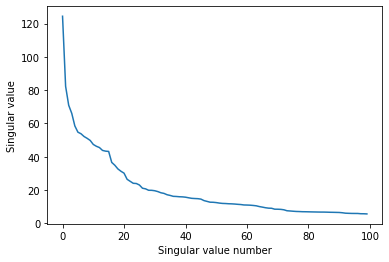

In [51]:
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [92]:
N_FEATS = 10

In [93]:
docs_compressed, s, words_compressed = svds(song_tag_mat, k=N_FEATS)
words_compressed = words_compressed.transpose()

In [94]:
words_compressed_normed = normalize(words_compressed, axis = 1)

In [95]:
def closest_words(word_in, words_representation_in, k = 10):
    if word_in not in tag_to_index: return "Not in vocab."
    sims = words_representation_in.dot(words_representation_in[tag_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_tag[i],sims[i]) for i in asort[1:]]

In [96]:
td_matrix_np = song_tag_mat.transpose()
td_matrix_np = normalize(td_matrix_np)

In [104]:
word = 'energetic'
print("Using SVD:")
for w, sim in closest_words(word, words_compressed_normed):
    try:
        print("{}, {:.3f}".format(w, sim))
    except:
        print("word not found")
print()

Using SVD:
annoying, 0.889
exciting, 0.880
thrill, 0.780
lively, 0.780
gleeful, 0.770
playful, 0.760
anxious, 0.757
boisterous, 0.749
rambunctious, 0.744
fierce, 0.742



In [98]:
for i in range(N_FEATS):
    print("Top words in dimension", i)
    dimension_col = words_compressed[:,i].squeeze()
    asort = np.argsort(-dimension_col)
    print([index_to_tag[i] for i in asort[:10]])
    print()

Top words in dimension 0
['romantic', 'melancholic', 'dark', 'mellow', 'energetic', 'fun', 'depressive', 'intense', 'smooth', 'aggressive']

Top words in dimension 1
['melancholy', 'romantic', 'party', 'smooth', 'fun', 'bittersweet', 'sexy', 'heartbreak', 'soft', 'heartbreaking']

Top words in dimension 2
['happy', 'party', 'dark', 'sexy', 'melancholy', 'dreamy', 'energetic', 'mellow', 'intense', 'joyful']

Top words in dimension 3
['happy', 'fun', 'sexy', 'melancholy', 'dark', 'melancholic', 'dreamy', 'funny', 'intense', 'humor']

Top words in dimension 4
['melancholy', 'party', 'melancholic', 'dreamy', 'dark', 'relax', 'relaxing', 'calm', 'intense', 'soothing']

Top words in dimension 5
['relax', 'romantic', 'relaxing', 'happy', 'soft', 'smooth', 'calm', 'dreamy', 'soothing', 'peaceful']

Top words in dimension 6
['happy', 'fun', 'melancholy', 'sad', 'mellow', 'party', 'melancholic', 'funny', 'energetic', 'cheerful']

Top words in dimension 7
['sad', 'melancholy', 'melancholic', 'dar

In [126]:
query = "happy calm peaceful"
query_tagf = np.zeros((1,len(unique_tags)))
for wrd in query.split():
    if wrd in unique_tags:
        i = tag_to_index[wrd]
        query_tagf[0,i] += 1

In [135]:
docs_compressed_normed = normalize(docs_compressed, axis=1)

In [177]:
def closest_songs_to_query(query_vec_in, k = 5):
    sims = normalize(query_vec_in).dot(docs_compressed_normed.T)[0]
    asort = np.argsort(-sims)[:k+1]
    return [(i, big_df['title'].iloc[i],sims[i]) for i in asort[0:]]

In [178]:
def match_on_emotion_query(query):
    query_tagf = np.zeros((1,len(unique_tags)))
    for wrd in query.split():
        if wrd in unique_tags:
            i = tag_to_index[wrd]
            query_tagf[0,i] += 1
    query_vec = query_tagf @ words_compressed
    closest = closest_songs_to_query(query_vec)
    print("Closest songs to query: {}".format(query))
    for i, proj, sim in closest_songs_to_query(query_vec):
        print("{}, {:.2f}".format(proj, sim))

In [179]:
match_on_emotion_query("happy peaceful")

Closest songs to query: happy peaceful
Hippopotamus, 0.99
Phantasies, 0.99
Mighty Man, 0.99
Doobie, 0.99
The Church Channel, 0.99
Tiger Is Not A Bird, 0.99


In [180]:
match_on_emotion_query("excited angry")

Closest songs to query: excited angry
Terror, 0.99
Spitfall, 0.99
Home, 0.99
Suffocate, 0.99
Operation, 0.99
The Futile, 0.99


In [181]:
match_on_emotion_query("excited angry angry")

Closest songs to query: excited angry angry
Suffocate, 0.99
Terror, 0.99
Operation, 0.99
Spitfall, 0.99
The Futile, 0.99
Home, 0.99


In [182]:
match_on_emotion_query("sad sad sad")

Closest songs to query: sad sad sad
Song About an Angel, 0.99
Stab My Back, 0.99
Fitter Happier, 0.99
Kingsport Town, 0.99
Hannah Hold On, 0.99
Miserable, 0.99
